# Purposes of this document

the goal of this jupyter is to run the BMIloop in steps  
we can  
1. understand what is happening. 
2. develop new components  

along these reasons,  
we will clearly point out where the components are  
we focus on how information is transmitted between components  

note all of this is in the branch sijia as of 2021 Jan


# setting up the simulation components

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

In [1]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow

import time
import copy
import numpy as np

/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  set up trial information

In [2]:
#generate task params
N_TARGETS = 8
N_TRIALS = 8
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

##  simulation encoder decoder setup

In [3]:
#clda on random 
DECODER_MODE = 'trainedKF' # in this case we load simulation_features.SimKFDecoderRandom
ENCODER_TYPE = 'cosine_tuned_encoder'
LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


SAVE_HDF = False

SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist

DEBUG_FEATURE = False

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'toy')

features.simulation_features: get_enc_setup has a tuning_level of 1 



## from the setup options, set up experiment

In [4]:
# set up assist level
assist_level = (0, 0)

#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow
feats = []

#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')
    
    
   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')
    
    
#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)




#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


#save everthing in a kw
kwargs = dict()
kwargs['sim_C'] = sim_C

__main__: selected SimCosineTunedEnc

__main__: set decoder to SimKFDecoderSup



## seed the exp

In [5]:
np.random.seed(0)

## make our experiment class

In [6]:
#spawn the task
Exp = experiment.make(base_class, feats=feats)
#print(Exp)
exp = Exp(seq, **kwargs)
exp.init()

metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderSup'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderSup'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]

features.simulation_features.SimIntentionL

## test run a bit

print(exp.state)
exp.run() 

# now comes to the step through BMIloop


## decode neural features to move cursor
this section basically steps through the move_plant stuff

@riglib.bmi.BMILoop.move_plant

# assemble into a complete loop

In [7]:
# riglib.experiment: line 597 - 601
#exp.next_trial = next(exp.gen)
# -+exp._parse_next_trial()


# we need to set the initial state
# per fsm.run:  line 138


# Initialize the FSM before the loop
exp.set_state(exp.state)


while exp.state is not None:

    # exp.fsm_tick()

    ### Execute commands#####
    exp.exec_state_specific_actions(exp.state)

    ###run the bmi loop #####
    # _cycle

    # bmi feature extraction, eh
    #riglib.bmi: 1202
    feature_data = exp.get_features()

    # Determine the target_state and save to file
    current_assist_level = exp.get_current_assist_level()
    if np.any(current_assist_level > 0) or exp.learn_flag:
        target_state = exp.get_target_BMI_state(exp.decoder.states)
    else:
        target_state = np.ones(
            [exp.decoder.n_states, exp.decoder.n_subbins]) * np.nan

    # decode the new features
    # riglib.bmi.bmiloop: line 1245
    neural_features = feature_data[exp.extractor.feature_type]

    # call decoder.
    #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
    neural_obs = neural_features
    learn_flag = exp.learn_flag
    task_state = exp.state

    n_units, n_obs = neural_obs.shape
    # If the target is specified as a 1D position, tile to match
    # the number of dimensions as the neural features
    if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
        target_state = np.tile(target_state, [1, n_obs])

    decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
    update_flag = False

    for k in range(n_obs):
        neural_obs_k = neural_obs[:, k].reshape(-1, 1)
        target_state_k = target_state[:, k]

        # NOTE: the conditional below is *only* for compatibility with older Carmena
        # lab data collected using a different MATLAB-based system. In all python cases,
        # the task_state should never contain NaN values.
        if np.any(np.isnan(target_state_k)):
            task_state = 'no_target'

        #################################
        # Decode the current observation
        #################################
        decodable_obs, decode = exp.bmi_system.feature_accumulator(
            neural_obs_k)
        if decode:  # if a new decodable observation is available from the feature accumulator
            prev_state = exp.bmi_system.decoder.get_state()

            exp.bmi_system.decoder(decodable_obs, **kwargs)
            # Determine whether the current state or previous state should be given to the learner
            if exp.bmi_system.learner.input_state_index == 0:
                learner_state = exp.bmi_system.decoder.get_state()
            elif exp.bmi_system.learner.input_state_index == -1:
                learner_state = prev_state
            else:
                print(("Not implemented yet: %d" %
                       exp.bmi_system.learner.input_state_index))
                learner_state = prev_state

            if learn_flag:
                exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

        decoded_states[:, k] = exp.bmi_system.decoder.get_state()

        ############################
        # Update decoder parameters
        ############################
        if exp.bmi_system.learner.is_ready():
            batch_data = exp.bmi_system.learner.get_batch()
            batch_data['decoder'] = exp.bmi_system.decoder
            kwargs.update(batch_data)
            exp.bmi_system.updater(**kwargs)
            exp.bmi_system.learner.disable()

        new_params = None  # by default, no new parameters are available
        if exp.bmi_system.has_updater:
            new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

        # Update the decoder if new parameters are available
        if not (new_params is None):
            exp.bmi_system.decoder.update_params(
                new_params, **exp.bmi_system.updater.update_kwargs)
            new_params['intended_kin'] = batch_data['intended_kin']
            new_params['spike_counts_batch'] = batch_data['spike_counts']

            exp.bmi_system.learner.enable()
            update_flag = True

            # Save new parameters to parameter history
            exp.bmi_system.param_hist.append(new_params)

    # saved as task data
    # return decoded_states, update_flag
    tmp = decoded_states
    exp.task_data['internal_decoder_state'] = tmp

    # reset the plant position
    # @riglib.bmi.BMILoop.move_plant  line:1254
    exp.plant.drive(exp.decoder)

    # check state transitions and run the FSM.
    current_state = exp.state

    # iterate over the possible events which could move the task out of the current state
    for event in exp.status[current_state]:
        # if the event has occurred
        if exp.test_state_transition_event(event):
            # execute commands to end the current state
            exp.end_state(current_state)

            # trigger the transition for the event
            exp.trigger_event(event)

            # stop searching for transition events (transition events must be
            # mutually exclusive for this FSM to function properly)
            break

    # sort out the loop params.
    # inc cycle count
    exp.cycle_count += 1

    # save target data as was done in manualControlTasks._cycle
    exp.task_data['target'] = exp.target_location.copy()
    exp.task_data['target_index'] = exp.target_index
    # as well as plant data.
    plant_data = exp.plant.get_data_to_save()
    for key in plant_data:
        exp.task_data[key] = plant_data[key]

    # clda data handled in the above call.

    # save to the list hisory of data.
    exp.task_data_hist.append(exp.task_data.copy())


if exp.verbose:
    print("end of FSM.run, task state is", exp.state)

0.0
runseq
0.0
0.0
0.0
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


KFSmoothbatch: calculating new SB parameters
1.0
1.0
1.0
1.0
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
2.0
2.0
2.0
2.0
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
3.0
3.0
3.0
3.0
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
4.0
4.0
4.0
4.0
KFSmoothbatch: calculating new SB pa

# save the object to local

exp.__dict__.keys()

import types
import _thread

for key_val in exp.__dict__.keys():
    if isinstance(exp.__dict__[key_val], types.GeneratorType): print(key_val)
    if isinstance(exp.__dict__[key_val], _thread.lock): print(key_val)

if 'gen' in exp.__dict__.keys():  del  exp.__dict__['gen']

import pickle
with open("exp_1.bin","wb") as picke_file:
    pickle.dump(exp.__dict__, picke_file)

# Analyze saved parameters file

import json

with open('exp_1.json', "w") as f:
    json.dump(exp.__dict__, f)

In [8]:
import  matplotlib.pyplot as plt

In [9]:
task_data_hist_np = np.array(exp.task_data_hist)


In [10]:
task_data_hist_np.dtype

dtype([('cursor', '<f8', (3,)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (4, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

In [11]:
cursor_trajectory = np.squeeze(task_data_hist_np['cursor'])

In [12]:
cursor_trajectory.shape

(3064, 3)

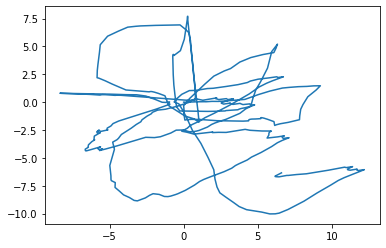

In [13]:
plt.plot(cursor_trajectory[:,0], cursor_trajectory[:,2])

In [14]:
exp.calc_state_occurrences('reward')

8

## Analysis of neural data

In [15]:
clda_params = np.array(exp.bmi_system.param_hist)

clda_params_dict = dict()
for param_key in clda_params[0].keys():
    clda_params_dict[param_key] = np.array([ record_i[param_key] for record_i in clda_params])


In [16]:
clda_params_dict.keys()

dict_keys(['kf.C', 'kf.Q', 'kf.C_xpose_Q_inv_C', 'kf.C_xpose_Q_inv', 'mFR', 'sdFR', 'rho', 'intended_kin', 'spike_counts_batch'])

In [17]:
mat_kf_c = clda_params_dict['kf.C']

In [18]:
import sympy as sp
sp.Matrix(clda_params_dict['kf.C'][0])

Matrix([
[0.0, 0.0, 0.0,    0.052481947573899, 0.0,  0.00242509728076033, 0.106541472789429],
[0.0, 0.0, 0.0,  -0.0501436333026243, 0.0, -0.00167508229170841, 0.107348919464597],
[0.0, 0.0, 0.0, -0.00635951378166361, 0.0,   0.0521566354225038, 0.109161040609606],
[0.0, 0.0, 0.0,  0.00342195868526427, 0.0,  -0.0493998209052616,  0.10727868244058]])

In [19]:
from weights import *
tuning_angles = cal_tuning_angle(mat_kf_c)


Text(0, 0.5, 'tuning angle (deg)')

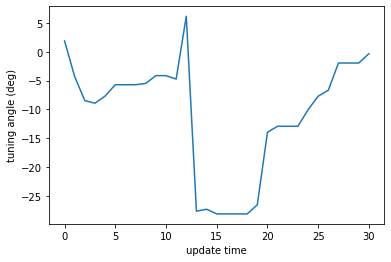

In [20]:
plt.plot(tuning_angles[:,1])
plt.xlabel('update time')
plt.ylabel('tuning angle (deg)') 

Text(0, 0.5, 'tuning angle (deg)')

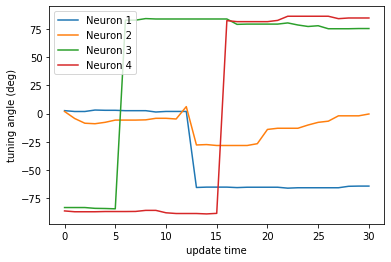

In [21]:
plt.plot(tuning_angles )
plt.legend(['Neuron 1', 'Neuron 2', 'Neuron 3', 'Neuron 4'])
plt.xlabel('update time')
plt.ylabel('tuning angle (deg)')

In [22]:
sp.Matrix(sim_C)

Matrix([
[0.0, 0.0, 0.0,  1.0, 0.0,  0.0, 0.0],
[0.0, 0.0, 0.0, -1.0, 0.0,  0.0, 0.0],
[0.0, 0.0, 0.0,  0.0, 0.0,  1.0, 0.0],
[0.0, 0.0, 0.0,  0.0, 0.0, -1.0, 0.0]])